# Unlocking Barça's Bench Power

A Data-Driven Analysis of FC Barcelona's Bench Strength

Ever wondered who really changes the game when they come off the bench for FC Barcelona? This project dives into the stats to find out! We're building a "Super Sub Detector" – a cool way to see which players pack the biggest punch as substitutes. Forget gut feelings, we're using data to find Barça's secret weapons and even suggest who to bring on in tricky match situations!

# 1: Setup - Importing Libraries and Loading Data

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 

player_stats_df = pd.read_csv('results_from_firecrawl_1_barca_subs_dataset.csv')
goal_logs_df = pd.read_csv('results_goal_logs.csv')
match_logs_df = pd.read_csv('firecrawl_playground_results_matches.csv')

print("--- Player Stats (First 3 rows) ---")
print(player_stats_df.head(3))
print(f"Shape: {player_stats_df.shape}\n")

print("--- Goal Logs (First 3 rows) ---")
print(goal_logs_df.head(3))
print(f"Shape: {goal_logs_df.shape}\n")

print("--- Match Logs (First 3 rows) ---")
print(match_logs_df.head(3))
print(f"Shape: {match_logs_df.shape}\n")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

--- Player Stats (First 3 rows) ---
   MP_xG  MP_mins  MP_goals   Sh  Age   Min    Pos  SoT_G-xG  SoT_G/SoT  \
0    2.4     4418         4   30   26  4418     DF      -0.4       0.36   
1   22.6     4316        32  179   28  4316  FW,MF       6.4       0.42   
2    2.6     4313         6   38   22  4313     MF       1.4       0.40   

   Subs_xG±  Subs_Mn/Sub  Subs_on/off_±  Subs_Subs_count Nation        Player  \
0      1.13           21           1.71                3    FRA  Jules Koundé   
1      1.17           35           1.75                4    BRA      Raphinha   
2      1.15           24           1.61                3    ESP         Pedri   

   Starts  
0      50  
1      49  
2      52  
Shape: (39, 16)

--- Goal Logs (First 3 rows) ---
   rk    xg     comp        date             gca1            gca2  psxg  \
0   1  0.87  La Liga  2024-08-17     Lamine Yamal             NaN  0.99   
1   2  0.79  La Liga  2024-08-17         Raphinha   Ferrán Torres  0.98   
2   3  0.02  La

# 2: Data Cleaning and Exploration (Player Stats)

on the player_stats_df. We'll check for missing values and ensure data types are appropriate. We'll also look at some basic distributions of key substitute-related columns.

In [68]:
print("--- Player Stats Info ---")
player_stats_df.info()

print("\n--- Missing Values in Player Stats (Sum) ---")
print(player_stats_df.isnull().sum().sort_values(ascending=False).head())

# Convert relevant columns to numeric
cols_to_numeric = ['MP_xG', 'MP_mins', 'MP_goals', 'Sh', 'Age', 'Min',
                   'SoT_G-xG', 'SoT_G/SoT', 'Subs_xG±', 'Subs_Mn/Sub',
                   'Subs_on/off_±', 'Subs_Subs_count', 'Starts']
for col in cols_to_numeric:
    if col in player_stats_df.columns:
        player_stats_df[col] = pd.to_numeric(player_stats_df[col], errors='coerce')

print("\n--- Descriptive Stats for Key Sub Columns ---")
key_sub_cols = ['Subs_xG±', 'Subs_Mn/Sub', 'Subs_on/off_±', 'Subs_Subs_count']
print(player_stats_df[key_sub_cols].describe())

--- Player Stats Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MP_xG            39 non-null     float64
 1   MP_mins          39 non-null     int64  
 2   MP_goals         39 non-null     int64  
 3   Sh               39 non-null     int64  
 4   Age              39 non-null     int64  
 5   Min              39 non-null     int64  
 6   Pos              39 non-null     object 
 7   SoT_G-xG         39 non-null     float64
 8   SoT_G/SoT        39 non-null     float64
 9   Subs_xG±         39 non-null     float64
 10  Subs_Mn/Sub      39 non-null     int64  
 11  Subs_on/off_±    39 non-null     float64
 12  Subs_Subs_count  39 non-null     int64  
 13  Nation           39 non-null     object 
 14  Player           39 non-null     object 
 15  Starts           39 non-null     int64  
dtypes: float64(5), int64(8), object(3)
mem

# 3: Feature Engineering from Player Stats

We create new features from the player_stats_df that will be useful for our "Super Sub Impact Score". This includes total minutes played as a sub and the ratio of sub appearances to total appearances.

In [71]:
player_features_df = player_stats_df.copy()

# Calculate Total Minutes as Sub
player_features_df['Subs_Subs_count'] = player_features_df['Subs_Subs_count'].fillna(0)
player_features_df['Subs_Mn/Sub'] = player_features_df['Subs_Mn/Sub'].fillna(0)
player_features_df['TotalSubMinutes'] = player_features_df['Subs_Subs_count'] * player_features_df['Subs_Mn/Sub']

# Calculate Sub Appearance Ratio
player_features_df['Starts'] = player_features_df['Starts'].fillna(0)
total_appearances = player_features_df['Starts'] + player_features_df['Subs_Subs_count']
player_features_df['SubAppearanceRatio'] = np.where(
    total_appearances > 0,
    player_features_df['Subs_Subs_count'] / total_appearances,
    0
)

print("--- Player Features (Excerpt with new features) ---")
print(player_features_df[['Player', 'Starts', 'Subs_Subs_count', 'TotalSubMinutes', 'SubAppearanceRatio']].head())

--- Player Features (Excerpt with new features) ---
         Player  Starts  Subs_Subs_count  TotalSubMinutes  SubAppearanceRatio
0  Jules Koundé      50                3               63            0.056604
1      Raphinha      49                4              140            0.075472
2         Pedri      52                3               72            0.054545
3  Lamine Yamal      47                4              164            0.078431
4   Pau Cubarsí      45                7              189            0.134615


# 4: Processing Goal Logs for Substitute Contributions

processes goal_logs_df. We are interested in goals, assists, and goal-creating actions (GCA1, GCA2) that were performed by players who came on as substitutes (start == 'N'). We aggregate these contributions per player.

In [74]:
# Identify goals scored by substitutes (scorer's 'start' status was 'N')
sub_scorers_df = goal_logs_df[goal_logs_df['start'] == 'N'][['scorer', 'xg']].copy()
sub_goals_count = sub_scorers_df.groupby('scorer').size().reset_index(name='SubGoals')
sub_goals_xg = sub_scorers_df.groupby('scorer')['xg'].sum().reset_index(name='SubGoals_xG_ShotTotal')

# Merge SubGoals into player_features_df
player_features_df = pd.merge(player_features_df, sub_goals_count, left_on='Player', right_on='scorer', how='left')
player_features_df.drop(columns=['scorer'], inplace=True, errors='ignore')
player_features_df['SubGoals'] = player_features_df['SubGoals'].fillna(0).astype(int)

player_features_df = pd.merge(player_features_df, sub_goals_xg, left_on='Player', right_on='scorer', how='left')
player_features_df.drop(columns=['scorer'], inplace=True, errors='ignore')
player_features_df['SubGoals_xG_ShotTotal'] = player_features_df['SubGoals_xG_ShotTotal'].fillna(0)

print("--- Player Features with Sub Goals (Top 5 by SubGoals) ---")
print(player_features_df[['Player', 'Subs_Subs_count', 'SubGoals', 'TotalSubMinutes']].sort_values(by='SubGoals', ascending=False).head())
# Note: Assists/GCAs by subs are not directly extracted due to data limitations
# We rely on overall impact metrics like Subs_xG± for broader sub influence

--- Player Features with Sub Goals (Top 5 by SubGoals) ---
                Player  Subs_Subs_count  SubGoals  TotalSubMinutes
12       Ferrán Torres               26         9              546
6   Robert Lewandowski                5         3              125
15           Dani Olmo               15         3              435
14         Eric García               26         2              572
21         Pablo Torre                9         2              126


# 5: Calculating Sub Contributions per 90 Minutes

To compare players fairly, regardless of how many minutes they played as subs, we calculate SubGoalsPer90SubMinutes. We also consider SoT_G-xG (finishing over/under performance) as a general indicator of attacking threat.

In [77]:
# Calculate SubGoalsPer90SubMinutes
player_features_df['SubGoalsPer90SubMinutes'] = np.where(
    player_features_df['TotalSubMinutes'] > 0,
    (player_features_df['SubGoals'] * 90) / player_features_df['TotalSubMinutes'],
    0
)

# Use existing 'SoT_G-xG' as FinishingImpact
player_features_df['FinishingImpact'] = player_features_df['SoT_G-xG'].fillna(0)

print("--- Player Features with Per 90 Sub Stats (Top 5 by SubGoalsPer90SubMinutes) ---")
print(player_features_df[['Player', 'SubGoals', 'TotalSubMinutes', 'SubGoalsPer90SubMinutes', 'FinishingImpact']].sort_values(by='SubGoalsPer90SubMinutes', ascending=False).head())

--- Player Features with Per 90 Sub Stats (Top 5 by SubGoalsPer90SubMinutes) ---
                Player  SubGoals  TotalSubMinutes  SubGoalsPer90SubMinutes  \
6   Robert Lewandowski         3              125                 2.160000   
12       Ferrán Torres         9              546                 1.483516   
21         Pablo Torre         2              126                 1.428571   
1             Raphinha         1              140                 0.642857   
15           Dani Olmo         3              435                 0.620690   

    FinishingImpact  
6               1.2  
12              2.9  
21              2.2  
1               6.4  
15              3.1  


# 6: Defining and Calculating the "Super Sub Impact Score"


This is the core of our model. We select key features that define a "super sub." We normalize these features using Min-Max scaling (to a 0-1 range) so they can be combined. Then, we apply weights to these normalized features and sum them up to get the SuperSubImpactScore. The weights are subjective but chosen to emphasize game-changing ability.

In [98]:
# Features for the Super Sub Impact Score
features_for_score = [
    'Subs_xG±',
    'Subs_on/off_±',
    'SubGoalsPer90SubMinutes',
    'SubAppearanceRatio',
    'FinishingImpact',
    'Subs_Subs_count'
]

score_df_for_scaling = player_features_df[['Player'] + features_for_score].copy()
for col in features_for_score:
    score_df_for_scaling[col] = score_df_for_scaling[col].fillna(0)

# Normalize the selected features using Min-Max Scaler
scaler = MinMaxScaler()
score_df_scaled_features = score_df_for_scaling.copy() 
score_df_scaled_features[features_for_score] = scaler.fit_transform(score_df_for_scaling[features_for_score])

# Define weights
weights = {
    'Subs_xG±': 0.30,
    'Subs_on/off_±': 0.25,
    'SubGoalsPer90SubMinutes': 0.20,
    'Subs_Subs_count': 0.10,
    'SubAppearanceRatio': 0.10,
    'FinishingImpact': 0.05
}

score_df_scaled_features['SuperSubImpactScore'] = 0
for feature, weight in weights.items():
    if feature in score_df_scaled_features.columns:
        score_df_scaled_features['SuperSubImpactScore'] += score_df_scaled_features[feature] * weight

player_features_df['SuperSubImpactScore'] = score_df_scaled_features['SuperSubImpactScore']

print("--- Top Players by Super Sub Impact Score ---")
cols_to_show = ['Player', 'SuperSubImpactScore', 'Subs_Subs_count', 'SubGoals', 'SubGoalsPer90SubMinutes', 'Subs_xG±']
print(player_features_df[cols_to_show].sort_values(by='SuperSubImpactScore', ascending=False).head(10))

--- Top Players by Super Sub Impact Score ---
                Player  SuperSubImpactScore  Subs_Subs_count  SubGoals  \
12       Ferrán Torres             0.774220               26         9   
22  Pau Victor Delgado             0.763340               25         1   
14         Eric García             0.720899               26         2   
6   Robert Lewandowski             0.713970                5         3   
21         Pablo Torre             0.709386                9         2   
15           Dani Olmo             0.684232               15         3   
10     Frenkie de Jong             0.645411               21         1   
13        Fermin López             0.642583               25         2   
16       Gerard Martín             0.620684               22         0   
1             Raphinha             0.604323                4         1   

    SubGoalsPer90SubMinutes  Subs_xG±  
12                 1.483516      0.99  
22                 0.360000      2.18  
14                 

# 7: Correlation Heatmap of Scoring Features

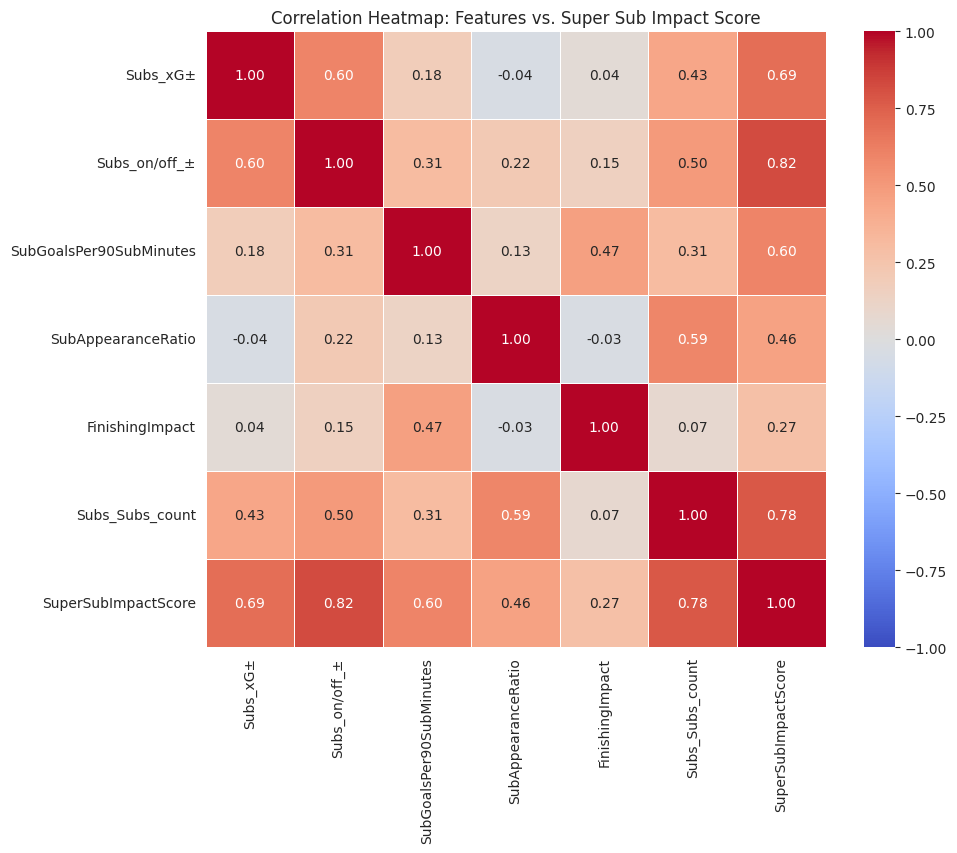


--- Heatmap Explanation ---
This heatmap shows how the (unscaled) input features correlate with each other and with the final 'SuperSubImpactScore'.
Red indicates positive correlation, blue negative. Values near 1 or -1 are strong, near 0 are weak.
It helps check if positively weighted features correlate positively with the score, and identify highly correlated input features.


In [101]:
# This cell uses the unscaled features (from score_df_for_scaling) and the final score
heatmap_data_df = score_df_for_scaling.copy() # Contains unscaled, NaN-filled features
heatmap_data_df['SuperSubImpactScore'] = player_features_df['SuperSubImpactScore'] 

# Calculate the correlation matrix
correlation_matrix = heatmap_data_df[features_for_score + ['SuperSubImpactScore']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Features vs. Super Sub Impact Score')
plt.show()

print("\n--- Heatmap Explanation ---")
print("This heatmap shows how the (unscaled) input features correlate with each other and with the final 'SuperSubImpactScore'.")
print("Red indicates positive correlation, blue negative. Values near 1 or -1 are strong, near 0 are weak.")
print("It helps check if positively weighted features correlate positively with the score, and identify highly correlated input features.")

# 8: Visualization - Top Super Subs and Score Components

We visualize the top-ranked "Super Subs" based on our calculated score. We also create a stacked bar chart for a few top players to show how different normalized components contribute to their total score.

/tmp/ipykernel_40/713753766.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_subs_df, x='SuperSubImpactScore', y='Player', palette='mako') # Changed palette


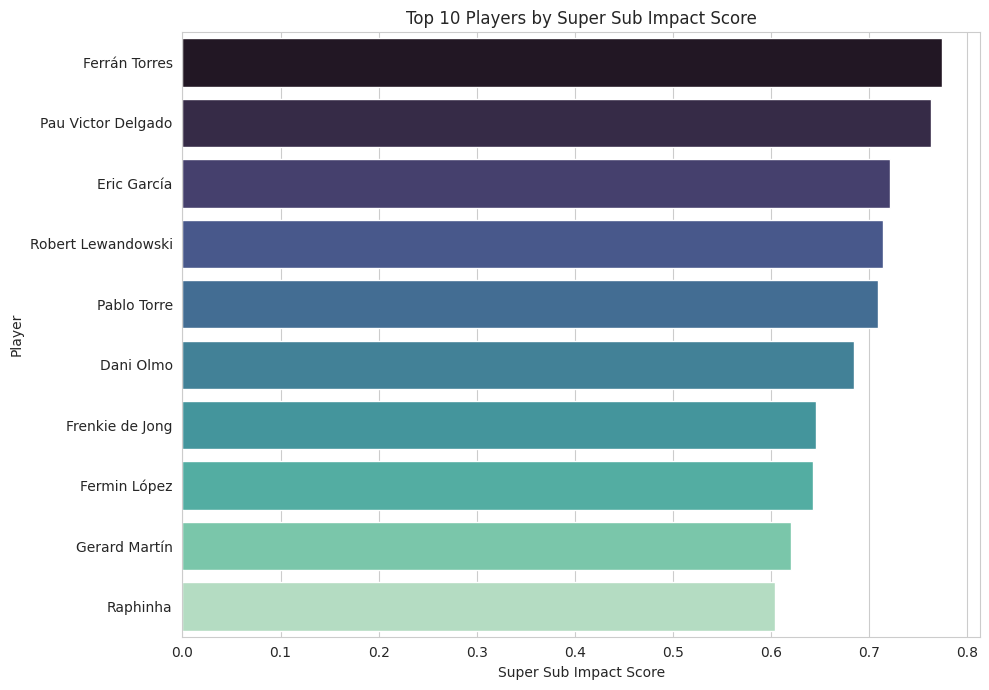

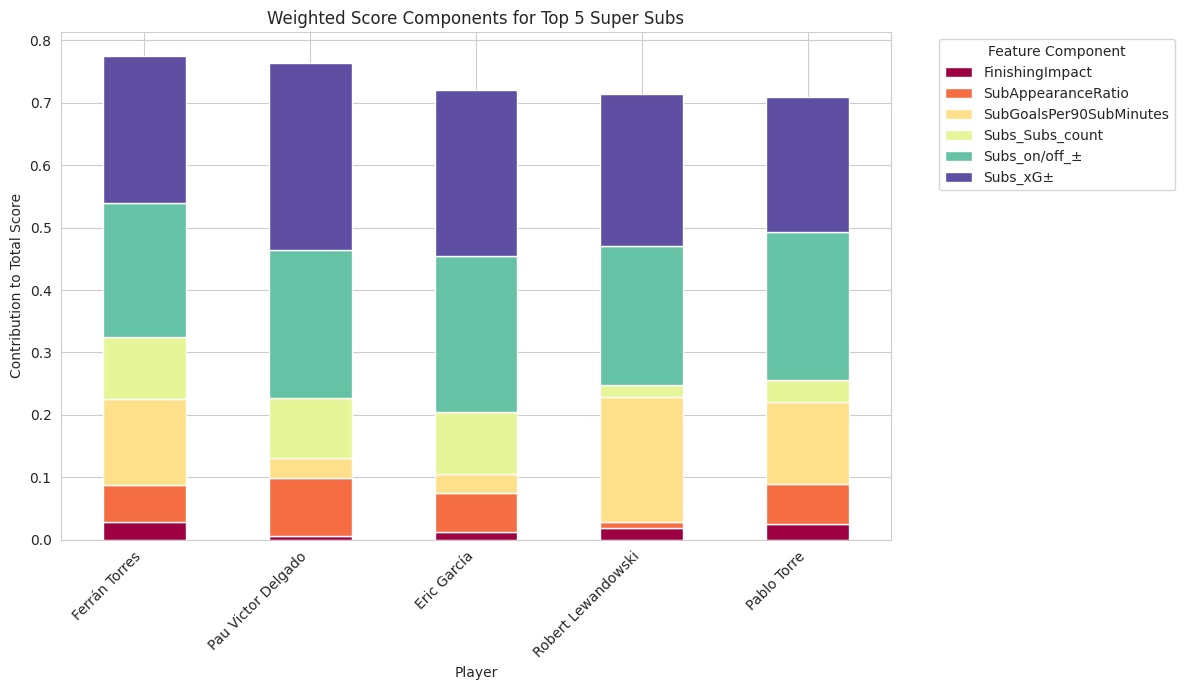

In [104]:
top_n = 10
top_subs_df = player_features_df.sort_values(by='SuperSubImpactScore', ascending=False).head(top_n)

plt.figure(figsize=(10, 7))
sns.barplot(data=top_subs_df, x='SuperSubImpactScore', y='Player', palette='mako') 
plt.title(f'Top {top_n} Players by Super Sub Impact Score')
plt.xlabel('Super Sub Impact Score')
plt.ylabel('Player')
plt.tight_layout()
plt.show()


top_5_for_components_plot = score_df_scaled_features[score_df_scaled_features['Player'].isin(top_subs_df['Player'].head(5))].copy()

plot_data_components = []
for idx, row in top_5_for_components_plot.iterrows():
    player_name = row['Player']
    for feature, weight in weights.items():
        if feature in row: 
             plot_data_components.append({
                'Player': player_name,
                'Feature': feature,
                'WeightedValue': row[feature] * weight 
            })
plot_df_components = pd.DataFrame(plot_data_components)

if not plot_df_components.empty:
    pivot_df = plot_df_components.pivot(index='Player', columns='Feature', values='WeightedValue')
    pivot_df = pivot_df.reindex(top_subs_df['Player'].head(5).tolist(), fill_value=0)
    
    pivot_df.plot(kind='bar', stacked=True, colormap='Spectral', figsize=(12,7))
    plt.title('Weighted Score Components for Top 5 Super Subs')
    plt.ylabel('Contribution to Total Score')
    plt.xlabel('Player')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Feature Component', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 9: Spotlight on Ferran Torres

this cell specifically checks Ferran Torres's rank and the components of his "Super Sub Impact Score" to see if our model aligns with the intuition that he is a strong substitute.


--- Spotlight on Ferrán Torres ---
       Player  SuperSubImpactScore  Subs_Subs_count  SubGoals  SubGoalsPer90SubMinutes  Subs_xG±  Subs_on/off_±
Ferrán Torres              0.77422               26         9                 1.483516      0.99           1.51

Ferrán Torres's Rank by Super Sub Impact Score: 1 out of 39
/tmp/ipykernel_40/3028007071.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ferran_plot_df, x='WeightedContribution', y='Feature', palette='crest')


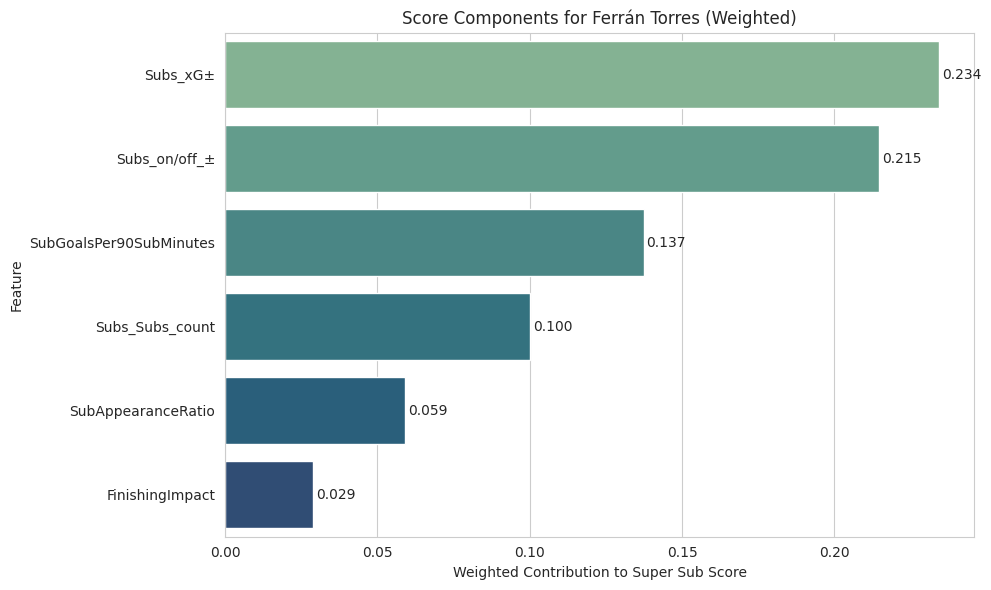

In [107]:
ferran_torres_name = 'Ferrán Torres'
ferran_torres_stats_row = player_features_df[player_features_df['Player'] == ferran_torres_name]

if not ferran_torres_stats_row.empty:
    print(f"\n--- Spotlight on {ferran_torres_name} ---")
    
    cols_to_show_spotlight = ['Player', 'SuperSubImpactScore', 'Subs_Subs_count', 'SubGoals', 'SubGoalsPer90SubMinutes', 'Subs_xG±', 'Subs_on/off_±']
    print(ferran_torres_stats_row[cols_to_show_spotlight].to_string(index=False))

    player_features_df_sorted = player_features_df.sort_values(by='SuperSubImpactScore', ascending=False).reset_index(drop=True)
    ferran_rank_series = player_features_df_sorted[player_features_df_sorted['Player'] == ferran_torres_name].index
    if not ferran_rank_series.empty:
        ferran_rank = ferran_rank_series[0] + 1
        print(f"\n{ferran_torres_name}'s Rank by Super Sub Impact Score: {ferran_rank} out of {len(player_features_df)}")

    # Visualization of Ferran Torres's score components
    ferran_scaled_components = score_df_scaled_features[score_df_scaled_features['Player'] == ferran_torres_name]
    if not ferran_scaled_components.empty:
        ferran_component_data = []
        for feature, weight in weights.items():
            if feature in ferran_scaled_components.columns:
                scaled_value = ferran_scaled_components[feature].iloc[0]
                weighted_contribution = scaled_value * weight
                ferran_component_data.append({'Feature': feature, 'WeightedContribution': weighted_contribution, 'NormalizedValue': scaled_value})
        
        ferran_plot_df = pd.DataFrame(ferran_component_data)
        ferran_plot_df = ferran_plot_df.sort_values(by='WeightedContribution', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=ferran_plot_df, x='WeightedContribution', y='Feature', palette='crest')
        plt.title(f'Score Components for {ferran_torres_name} (Weighted)')
        plt.xlabel('Weighted Contribution to Super Sub Score')
        plt.ylabel('Feature')
        # Add annotations for the actual weighted value
        for index, value in enumerate(ferran_plot_df['WeightedContribution']):
            plt.text(value + 0.001, index, f'{value:.3f}', va='center') # Adjust x for label position
        plt.tight_layout()
        plt.show()
    else:
        print(f"Could not retrieve scaled components for {ferran_torres_name} for visualization.")
else:
    print(f"{ferran_torres_name} not found in the dataset.")

# 10: Exploring Match Context 

This cell provides a brief look at the match_logs_df. We won't integrate this deeply into the player scoring for now, but it can offer context like performance in different competitions or typical game states. For instance, we can see how often Barcelona wins when their xG is higher than their opponent's xG.


--- Match Log Insights ---
Total matches in log: 56
Competitions covered: ['La Liga' 'Champions Lg' 'Copa del Rey' 'Supercopa de España']
/tmp/ipykernel_40/328089886.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=match_logs_df, x='result', order=['W', 'D', 'L'], palette={'W': 'green', 'D': 'orange', 'L': 'red'})


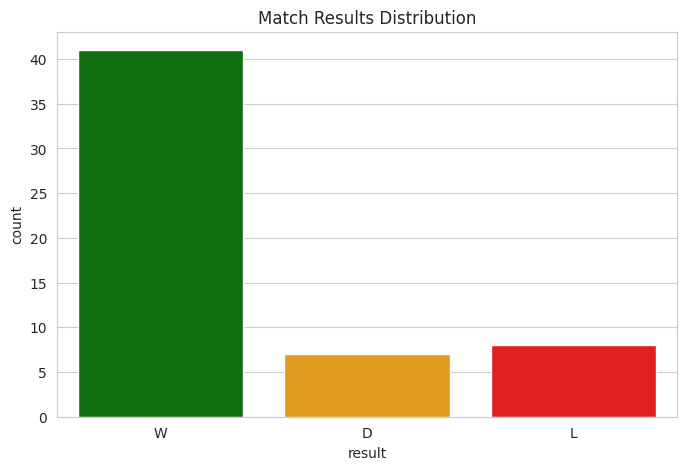

Average possession across all matches: 65.77%


In [110]:
print("\n--- Match Log Insights ---")
print(f"Total matches in log: {len(match_logs_df)}")
print(f"Competitions covered: {match_logs_df['competition'].unique()}")

plt.figure(figsize=(8, 5))
sns.countplot(data=match_logs_df, x='result', order=['W', 'D', 'L'], palette={'W': 'green', 'D': 'orange', 'L': 'red'})
plt.title('Match Results Distribution')
plt.show()

avg_possession = match_logs_df['possession'].mean()
print(f"Average possession across all matches: {avg_possession:.2f}%")

# 11: Match Scenario Simulation & Substitute Recommendation

This cell simulates a specific match situation: Barcelona is losing 0-1 against a tough opponent in the 70th minute and needs an offensive spark. We filter available players (those not typically high-minute starters) and recommend substitutes based on their SuperSubImpactScore and other relevant offensive metrics.

In [113]:
def recommend_subs_for_scenario(player_df, scenario_description, time_minute, current_score, need, num_recommendations=3):
    print(f"\n--- Match Scenario: {scenario_description} ---")
    print(f"Time: {time_minute} min | Score: {current_score} | Primary Need: {need}")

    if 'SuperSubImpactScore' not in player_df.columns:
        print("Error: SuperSubImpactScore not calculated.")
        return

    max_starts_for_filtering = player_df['Starts'].max()
    potential_subs = player_df[
        (player_df['Starts'] < max_starts_for_filtering * 0.7) & (player_df['Subs_Subs_count'] > 0)
    ].copy()

    if potential_subs.empty:
        print("No potential substitutes found based on criteria.")
        return

    scaler = MinMaxScaler() # Local scaler for scenario-specific normalization

    if need == "OFFENSIVE_SPARK":
        offensive_weights = {'SuperSubImpactScore': 0.5, 'SubGoalsPer90SubMinutes_normalized': 0.3, 'Subs_xG±_normalized': 0.2}
        metrics_to_normalize = ['SubGoalsPer90SubMinutes', 'Subs_xG±']
        for metric in metrics_to_normalize:
            if metric in potential_subs.columns and potential_subs[metric].nunique() > 1:
                potential_subs[f'{metric}_normalized'] = scaler.fit_transform(potential_subs[[metric]])
            else:
                potential_subs[f'{metric}_normalized'] = 0.0
        
        potential_subs['ScenarioFitScore'] = (
            potential_subs['SuperSubImpactScore'] * offensive_weights['SuperSubImpactScore'] +
            potential_subs.get('SubGoalsPer90SubMinutes_normalized', 0) * offensive_weights['SubGoalsPer90SubMinutes_normalized'] +
            potential_subs.get('Subs_xG±_normalized', 0) * offensive_weights['Subs_xG±_normalized']
        )
        ranked_subs = potential_subs.sort_values(by='ScenarioFitScore', ascending=False)
        
    elif need == "CONTROL_MIDFIELD" or need == "DEFENSIVE_STABILITY":
        print(f"Note: Current SuperSubImpactScore is primarily offensive. For {need}, considering Pos and Subs_on/off_±.")
        if 'Subs_on/off_±' in potential_subs.columns and potential_subs['Subs_on/off_±'].nunique() > 1 :
            potential_subs['Subs_on/off_±_normalized'] = scaler.fit_transform(potential_subs[['Subs_on/off_±']])
        else:
            potential_subs['Subs_on/off_±_normalized'] = 0.0
            
        potential_subs['ScenarioFitScore'] = (potential_subs['SuperSubImpactScore'] * 0.3 + potential_subs.get('Subs_on/off_±_normalized', 0) * 0.7)
        
        position_filter = "DF" if need == "DEFENSIVE_STABILITY" else "MF"
        ranked_subs = potential_subs[potential_subs['Pos'].str.contains(position_filter, na=False)].sort_values(by='ScenarioFitScore', ascending=False)

    else: # Default to general SuperSubImpactScore
        potential_subs['ScenarioFitScore'] = potential_subs['SuperSubImpactScore'] # For consistent display
        ranked_subs = potential_subs.sort_values(by='SuperSubImpactScore', ascending=False)

    print(f"\nTop {num_recommendations} Substitute Recommendations:")
    cols_to_display = ['Player', 'Pos', 'SuperSubImpactScore', 'ScenarioFitScore', 'SubGoals', 'Subs_xG±', 'Subs_Subs_count']
    display_cols_exist = [col for col in cols_to_display if col in ranked_subs.columns]
    
    if ranked_subs.empty:
        print("No suitable substitutes found for this specific need and position filter.")
    else:
        print(ranked_subs[display_cols_exist].head(num_recommendations).to_string(index=False))

# --- Define and Run Scenarios ---
if 'player_features_df' in globals() and not player_features_df.empty:
    recommend_subs_for_scenario(player_features_df, "El Clásico vs Real Madrid, need a goal", 70, "Barça 0 - 1 Real Madrid", "OFFENSIVE_SPARK", 3)
    print("-" * 50)
    recommend_subs_for_scenario(player_features_df, "Champions League, holding narrow lead", 80, "Barça 2 - 1 Opponent", "CONTROL_MIDFIELD", 2)
else:
    print("Player_features_df is not defined or empty. Skipping scenario simulation.")


--- Match Scenario: El Clásico vs Real Madrid, need a goal ---
Time: 70 min | Score: Barça 0 - 1 Real Madrid | Primary Need: OFFENSIVE_SPARK

Top 3 Substitute Recommendations:
            Player   Pos  SuperSubImpactScore  ScenarioFitScore  SubGoals  Subs_xG±  Subs_Subs_count
     Ferrán Torres    FW             0.774220          0.843280         9      0.99               26
       Pablo Torre FW,MF             0.709386          0.788333         2      0.68                9
Pau Victor Delgado    FW             0.763340          0.654470         1      2.18               25
--------------------------------------------------

--- Match Scenario: Champions League, holding narrow lead ---
Time: 80 min | Score: Barça 2 - 1 Opponent | Primary Need: CONTROL_MIDFIELD
Note: Current SuperSubImpactScore is primarily offensive. For CONTROL_MIDFIELD, considering Pos and Subs_on/off_±.

Top 2 Substitute Recommendations:
     Player   Pos  SuperSubImpactScore  ScenarioFitScore  SubGoals  Subs_xG±  S

## Project Summary & Discussion

This project developed a "Super Sub Recommender" for FC Barcelona, aiming to identify players who make the most significant impact when introduced as substitutes. The analysis leverages three datasets: detailed player season statistics (including substitute-specific metrics), goal logs, and match logs.

- Methodology:

## 1.  Data Integration & Feature Engineering:

- Player season stats (`results_from_firecrawl_1_barca_subs_dataset.csv`) formed the core, providing metrics like `Subs_xG±` (change in team's xG difference when sub is on) and `Subs_on/off_±`.

- New features were engineered: `TotalSubMinutes`, `SubAppearanceRatio`, `SubGoals` (goals scored by substitutes from `results_goal_logs.csv`), and `SubGoalsPer90SubMinutes`.

- `SoT_G-XG` was used as `FinishingImpact`.

## 2.  "Super Sub Impact Score" Creation:

A composite `SuperSubImpactScore` was developed using weighted, Min-Max scaled features: `Subs_xG±`, `Subs_on/off_±`, `SubGoalsPer90SubMinutes`, `SubAppearanceRatio`, `FinishingImpact`, and `Subs_Subs_count`.

## 3.  Analysis & Validation:

- Players were ranked by this score. Visualizations included top performers, score component breakdowns, and a correlation heatmap of features against the score.

- A spotlight analysis (including visualization) on Ferran Torres validated the model's ability to identify known impactful substitutes.

## 4.  Scenario-Based Recommendation:

 A function simulates match scenarios, re-ranking potential substitutes based on a `ScenarioFitScore` tailored to specific game needs (e.g., offensive spark, midfield control).

### Key Findings & Utility:

-  The `SuperSubImpactScore` offers a quantifiable, interpretable measure of substitute effectiveness.

- The correlation heatmap confirmed that features weighted positively in the score generally showed positive correlations with the final score.

- The scenario-based recommender provides a dynamic tool for tactical decision-making.

### Limitations:

- Subjectivity of weights in the scoring system.

- Limited granularity for attributing assists/GCAs to substitutes from the provided data.

- Primarily offensive focus; defensive impact needs more specific metrics.

### Future Improvements:

- Incorporate more granular play-by-play data.

- Develop robust metrics for defensive substitute impact.

- Explore machine learning regression models.

- Allow user-defined weights for the scoring system.

This project serves as a strong foundation for data-driven analysis of substitute impact in football.